# BPNet Vignette

Model predictions at some interesting locus-- LIN28A on chr1 is a good test candidate.

**Inputs**:
1. Cell type specific BPNet models
2. Bigwigs of tn5 insertions for each cell state

In [170]:
import pyBigWig
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import pyfaidx
import keras
import scipy
import math

import shap
from modisco.visualization import viz_sequence

In [11]:
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll
from shaputils import *

In [9]:
from pathlib import Path

In [10]:
# local
sys.path.append("/users/surag/kundajelab/surag-scripts/misc/")
import one_hot


## Load Input Data

In [12]:
# "old" cluster IDs
CELL_STATES = [5,4,8,2,7,1,16]

In [13]:
BIGWIG_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20201020_n62402/bigwigs/"

In [14]:
bigwigs = dict()

for x in CELL_STATES:
    bigwigs[x] = pyBigWig.open("{}/cluster_idx{}.bw".format(BIGWIG_BASE, x))

In [15]:
MODEL_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210414_gc_neg_filt256_in2346_out2000/"

In [16]:
# load models
models = dict()
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    for x in CELL_STATES:
        model_path = list(Path(MODEL_BASE).glob("cluster_idx{}/2021*/*.h5".format(x)))
        assert(len(model_path)==1)
        model_path = str(model_path[0])
        models[x] = keras.models.load_model(model_path)

In [17]:
model_count_explainers = dict()

# explainers
for x in CELL_STATES:
    model_count_explainers[x] = shap.explainers.deep.TFDeepExplainer(
            ([models[x].input[0], models[x].input[1]],
             tf.reduce_sum(models[x].outputs[1], axis=-1)),
            shuffle_several_times,
            combine_mult_and_diffref=combine_mult_and_diffref)

In [18]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [19]:
MODEL_INP_LEN = models[CELL_STATES[0]].input_shape[0][1]
MODEL_OUT_LEN = models[CELL_STATES[0]].output_shape[0][1]
print(MODEL_INP_LEN)
print(MODEL_OUT_LEN)

2346
2000


In [20]:
def softmax(x):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(norm_x)/np.sum(np.exp(norm_x), axis=1, keepdims=True)

Load common peaks across samples to compute normalization stats.

See `common_peaks.sh` script.

In [21]:
common_peaks = pd.read_csv("common_peaks.bed", 
                          sep='\t',
                          names=["chr", "start", "end"])
print(common_peaks.shape)
common_peaks.head()

(22988, 3)


,chr,start,end
0,chr1,629099,630037
1,chr1,630304,630483
2,chr1,630783,631392
3,chr1,631887,632362
4,chr1,632482,632837


## Processing

Run for a few common regions to get normalization stats.

In [22]:
COMMON_PEAKS_TO_SAMPLE = 128*10

In [23]:
sampled_common_peaks = common_peaks.sample(COMMON_PEAKS_TO_SAMPLE)

In [24]:
BATCH_SIZE=128

In [25]:
common_insertions = defaultdict(list)
model_common_preds = defaultdict(list)

for x in CELL_STATES:
    for i in tqdm(range(math.ceil(sampled_common_peaks.shape[0]/BATCH_SIZE))):
        cur_seqs = sampled_common_peaks[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        cur_raw_seqs = []
        cur_insertions = []
        for j, r in cur_seqs.iterrows():
            mid = (r['start']+r['end'])//2
            cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
            cur_insertions.append(np.nan_to_num(bigwigs[x].values(r["chr"], mid-(MODEL_OUT_LEN)//2, mid+(MODEL_OUT_LEN)//2)))

        cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)

        cur_prof, cur_pred = models[x].predict([cur_raw_seqs, 
                       np.zeros((cur_raw_seqs.shape[0],1)), 
                       np.zeros((cur_raw_seqs.shape[0],2000,2))])
        cur_prof = softmax(np.squeeze(cur_prof))
        
        # multiply by counts
        cur_prof = (cur_prof * (np.exp(cur_pred)-1))

        model_common_preds[x].append(cur_prof)
        common_insertions[x].append(cur_insertions)

    model_common_preds[x] = np.vstack(model_common_preds[x])
    common_insertions[x] = np.vstack(common_insertions[x])

100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


In [26]:
# explanations are slower, so do fewer
model_common_explains = defaultdict(list)

for x in CELL_STATES:
    for i in tqdm(range(1)):
        cur_seqs = sampled_common_peaks[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        cur_raw_seqs = []
        cur_insertions = []
        for j, r in cur_seqs.iterrows():
            mid = (r['start']+r['end'])//2
            cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
            cur_insertions.append(np.nan_to_num(bigwigs[x].values(r["chr"], mid-(MODEL_OUT_LEN)//2, mid+(MODEL_OUT_LEN)//2)))

        cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
        
        # explanations
        counts_shap_scores = model_count_explainers[x].shap_values(
            [cur_raw_seqs, 
             np.zeros((cur_raw_seqs.shape[0], 1))], progress_message=100)
        projected_shap_scores = np.multiply(cur_raw_seqs, counts_shap_scores[0])
        model_common_explains[x].append(projected_shap_scores)

    model_common_explains[x] = np.vstack(model_common_explains[x])

  0%|          | 0/1 [00:00<?, ?it/s]

Done 0 examples of 128
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done 100 examples of 128


  0%|          | 0/1 [00:00<?, ?it/s]

Done 0 examples of 128
Done 100 examples of 128


  0%|          | 0/1 [00:00<?, ?it/s]

Done 0 examples of 128
Done 100 examples of 128


  0%|          | 0/1 [00:00<?, ?it/s]

Done 0 examples of 128
Done 100 examples of 128


  0%|          | 0/1 [00:00<?, ?it/s]

Done 0 examples of 128
Done 100 examples of 128


  0%|          | 0/1 [00:00<?, ?it/s]

Done 0 examples of 128
Done 100 examples of 128


  0%|          | 0/1 [00:00<?, ?it/s]

Done 0 examples of 128
Done 100 examples of 128


100%|██████████| 1/1 [00:35<00:00, 35.18s/it]


In [27]:
SMOOTH_SIGMA=2

In [164]:
pred_upper_lims = dict()
pred_smoothed_upper_lims = dict()
pred_log_cts_median = dict()

insertions_upper_lims = dict()
insertions_smoothed_upper_lims = dict()
insertions_log_cts_median = dict()

explain_upper_lims = dict()
explain_lower_lims = dict()

Q = 0.999
IMP_LOW=0.00001

for x in CELL_STATES:
    pred_upper_lims[x] = np.quantile(model_common_preds[x], Q)
    pred_log_cts_median[x] = np.median(np.log(np.sum(model_common_preds[x], -1)))
    
    insertions_upper_lims[x] = np.quantile(common_insertions[x], Q)
    insertions_log_cts_median[x] = np.median(np.log(np.sum(common_insertions[x], -1)))
    
    # smoothed pred/insertions track
    pred_smoothed_upper_lims[x] = np.quantile(scipy.ndimage.gaussian_filter1d(model_common_preds[x], SMOOTH_SIGMA),
                                                   Q)
    insertions_smoothed_upper_lims[x] = np.quantile(scipy.ndimage.gaussian_filter1d(common_insertions[x], SMOOTH_SIGMA),
                                                   Q)
    
    # explanation-- remove 0s at each position (3 out of 4 bases)
    explain_upper_lims[x] = np.quantile(model_common_explains[x][model_common_explains[x]!=0], Q)
    explain_lower_lims[x] = np.quantile(model_common_explains[x][model_common_explains[x]!=0], IMP_LOW)

In [165]:
pred_upper_lims

{5: 36.950865425110905,
 4: 2.5849421114921585,
 8: 8.995945328712677,
 2: 21.674662073136073,
 7: 6.505247498989246,
 1: 8.60091883468629,
 16: 34.63563665008628}

In [166]:
pred_log_cts_median

{5: 7.6320634,
 4: 5.1990795,
 8: 6.344801,
 2: 7.3241577,
 7: 6.014208,
 1: 6.53485,
 16: 7.86313}

In [167]:
insertions_log_cts_median

{5: 8.162801312861697,
 4: 5.583496308781699,
 8: 6.722023398276051,
 2: 7.575071172997655,
 7: 6.1779441140506,
 1: 6.6086749342317335,
 16: 8.10892415597534}

In [161]:
insertions_smoothed_upper_lims

{5: 29.453412129351616,
 4: 2.7166770853045805,
 8: 7.014621580406885,
 2: 13.992732866028389,
 7: 4.570751125555765,
 1: 7.0704342097613235,
 16: 26.874422368618127}

In [169]:
explain_upper_lims

{5: 0.09080805560463096,
 4: 0.06809740742235544,
 8: 0.07285067962957573,
 2: 0.06561382257237613,
 7: 0.07287863002158783,
 1: 0.059221774983138596,
 16: 0.06748849058959558}

In [163]:
explain_lower_lims

{5: -0.07947540509943896,
 4: -0.07636631370874587,
 8: -0.046543235710459756,
 2: -0.04817489725871942,
 7: -0.05308238850209547,
 1: -0.03758578319035726,
 16: -0.0537896848652637}

## Rough Plot (Proper plotting in R)

In [171]:
LOC_CHR="chr16"
LOC_CENTER = 68737277 
GENE = "CDH1" 

# LIN28A prom chr1:26410794
# CDH1 prom chr16:68737277

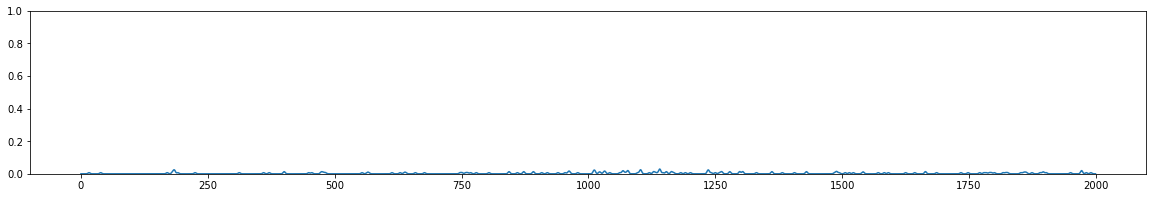

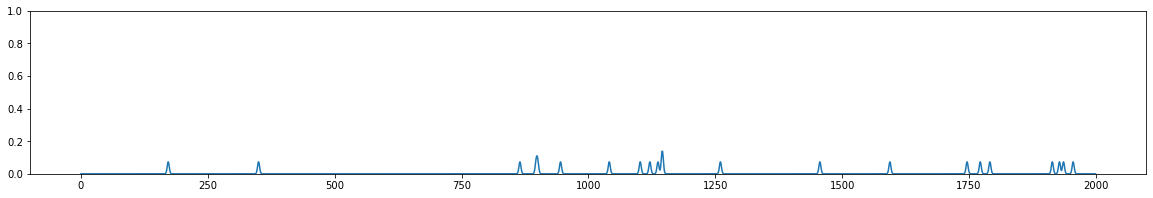

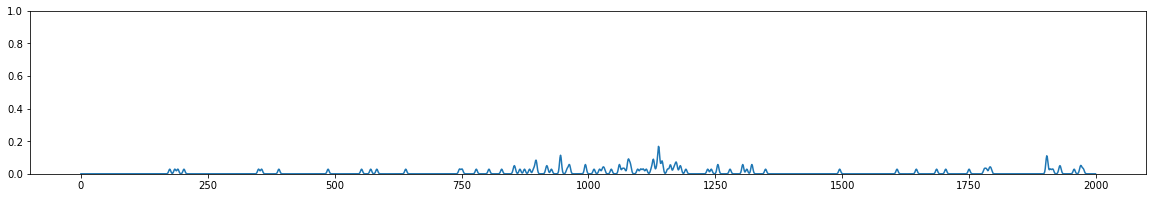

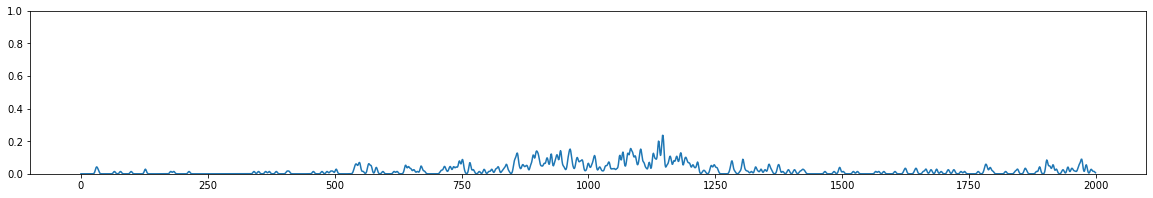

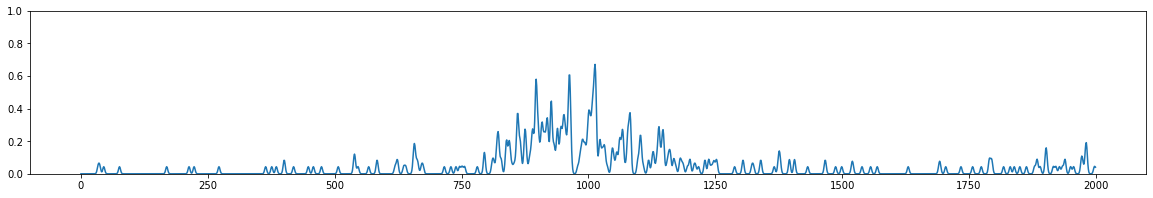

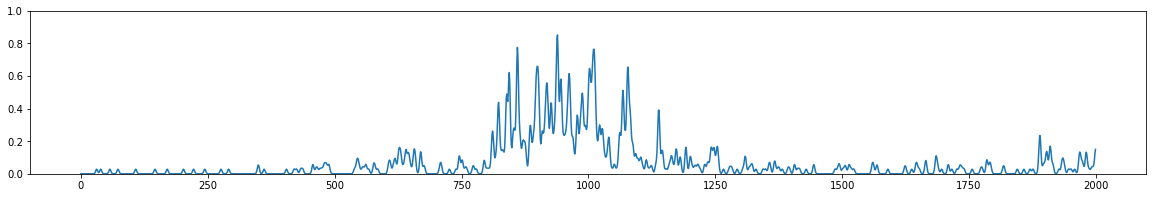

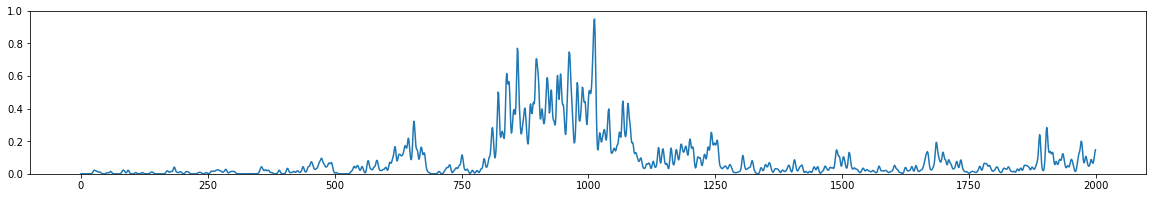

In [172]:
plt.rcParams["figure.figsize"] = (20,3)

for x in CELL_STATES:
    vals = np.nan_to_num(bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))
    
    plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(vals, SMOOTH_SIGMA)/insertions_smoothed_upper_lims[x])
    plt.ylim(0, 1)
    
#     plt.plot(range(MODEL_OUT_LEN), vals/insertions_upper_lims[x], linewidth=1)
#     plt.ylim(0, 1)
    
    plt.show()

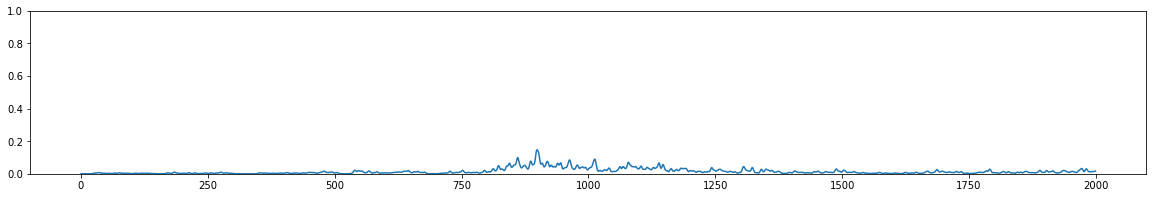

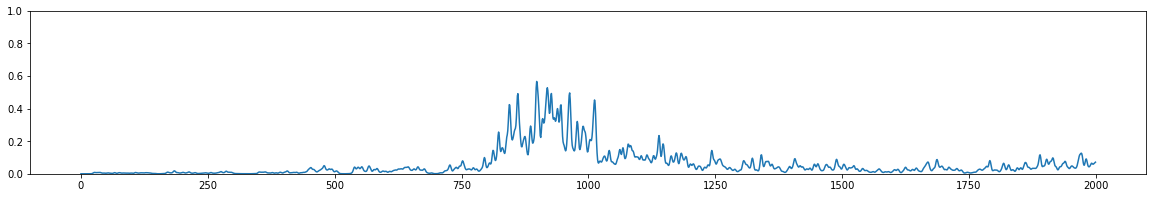

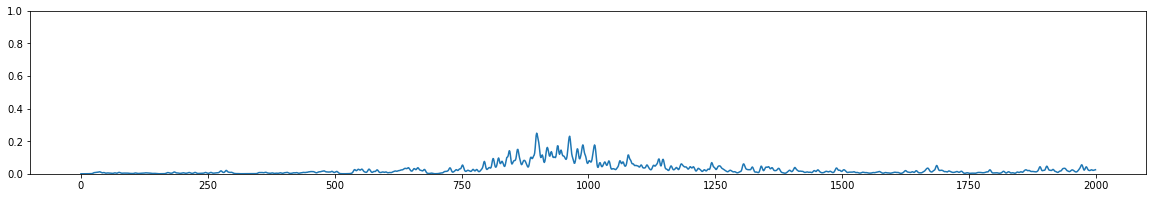

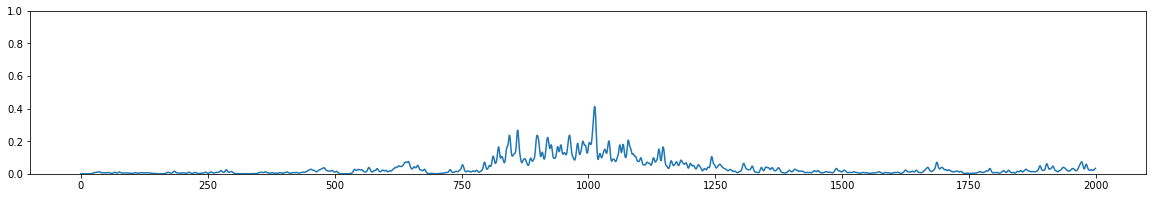

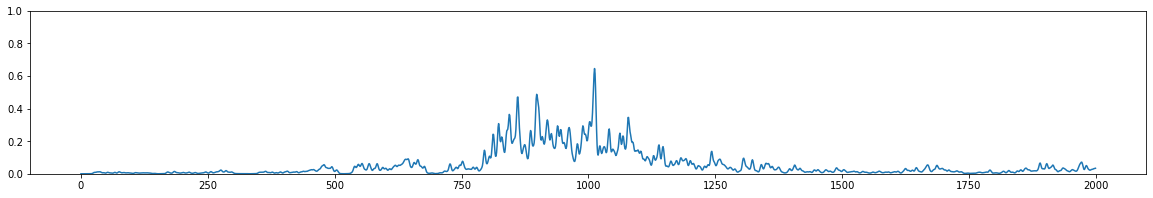

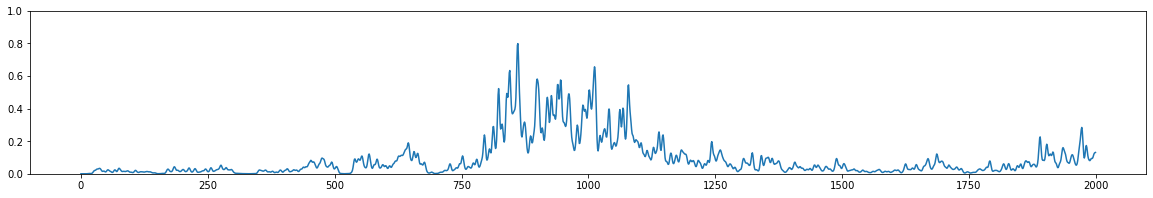

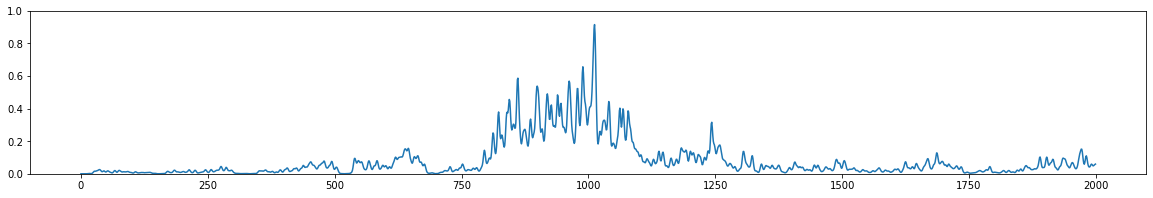

In [173]:
# model preds
seq = hg38[LOC_CHR][LOC_CENTER-(MODEL_INP_LEN)//2:LOC_CENTER+(MODEL_INP_LEN)//2]
seq = one_hot.dna_to_one_hot([str(seq)])

for x in CELL_STATES:
    # no control for now
    prof, cts = models[x].predict([seq, 
                      np.zeros((seq.shape[0],1)), 
                      np.zeros((seq.shape[0],MODEL_OUT_LEN,2))])
    prof = softmax(prof) * (np.exp(cts)-1)

#     plt.plot(range(MODEL_OUT_LEN), prof.ravel()/pred_upper_lims[x], linewidth=1)
#     plt.ylim(0, 1)
    
    plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(prof.ravel()/pred_smoothed_upper_lims[x], 
                                                                   SMOOTH_SIGMA))
    plt.ylim(0, 1)
    
    plt.show()   

In [174]:
for x in CELL_STATES:
    vals = np.nan_to_num(bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))
    vals_norm = vals.ravel()/insertions_upper_lims[x]
    
    print((np.log(np.sum(vals))) - (insertions_log_cts_median[x]-insertions_log_cts_median[5]))

5.062595033026967
5.670347457438314
6.168165733297987
7.106877427804438
8.073902074257944
8.4618816576121
8.55005098107852


In [175]:
for x in CELL_STATES:
    prof, cts = models[x].predict([seq, 
                      np.zeros((seq.shape[0],1)), 
                      np.zeros((seq.shape[0],MODEL_OUT_LEN,2))])
    
    print(cts[0][0]  + (pred_log_cts_median[5] - pred_log_cts_median[x]))

6.6641436
7.821249
7.1307745
7.330437
7.839758
8.093779
8.034521


Write to csv file to plot in R.

In [176]:
f = open("./vignette_intermediate/{}.prom.{}.{}.insertions.unsmoothed.tsv".format(GENE, LOC_CHR, LOC_CENTER), "w")

f.write("\t".join(["cluster_idx", "total_adjusted_cts"] + [str(x) for x in list(range(1,MODEL_OUT_LEN+1))]) + "\n")

for x in CELL_STATES:
    vals = np.nan_to_num(bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))
    vals_norm = vals.ravel()/insertions_upper_lims[x]
    log_cts_norm = np.log(np.sum(vals)) - (insertions_log_cts_median[x]-insertions_log_cts_median[5])
    
    f.write('\t'.join([str(x), str(log_cts_norm)] + [str(y) for y in vals_norm]) + '\n')
    
#     plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(vals, SMOOTH_SIGMA))
#     plt.ylim(0, insertions_smoothed_upper_lims[x])
f.close()

In [177]:
f = open("./vignette_intermediate/{}.prom.{}.{}.pred.unsmoothed.tsv".format(GENE, LOC_CHR, LOC_CENTER), "w")

f.write("\t".join(["cluster_idx", "predicted_adjusted_cts"] + [str(x) for x in list(range(1,MODEL_OUT_LEN+1))]) + "\n")

for x in CELL_STATES:
    prof, cts = models[x].predict([seq, 
                      np.zeros((seq.shape[0],1)), 
                      np.zeros((seq.shape[0],MODEL_OUT_LEN,2))])
    prof = softmax(prof) * (np.exp(cts)-1)
    
    vals_norm = prof.ravel()/pred_upper_lims[x]
    log_cts_norm = cts[0][0]  + (pred_log_cts_median[5] - pred_log_cts_median[x])
    
    f.write('\t'.join([str(x), str(log_cts_norm)] + [str(y) for y in vals_norm]) + '\n')
    
#     plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(vals, SMOOTH_SIGMA))
#     plt.ylim(0, insertions_smoothed_upper_lims[x])
f.close()

## Explanations

Done 0 examples of 1


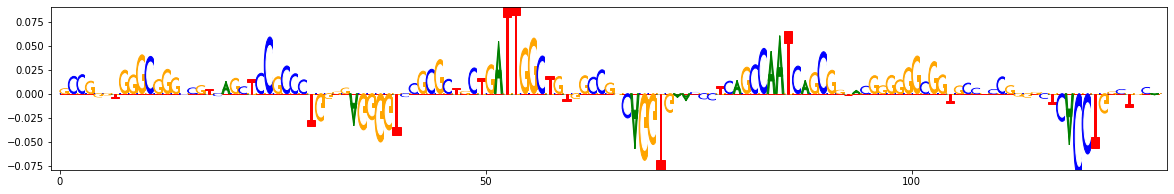

Done 0 examples of 1


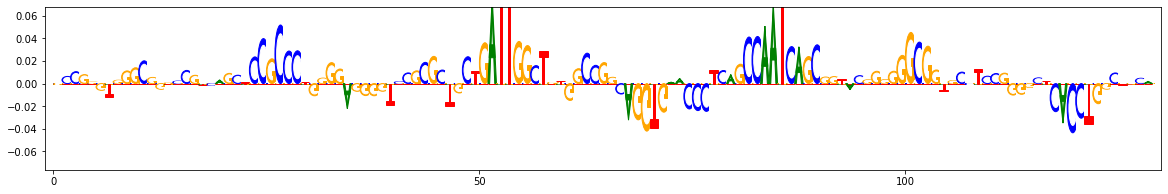

Done 0 examples of 1


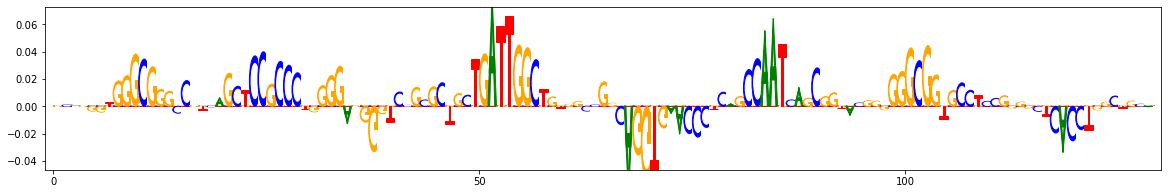

Done 0 examples of 1


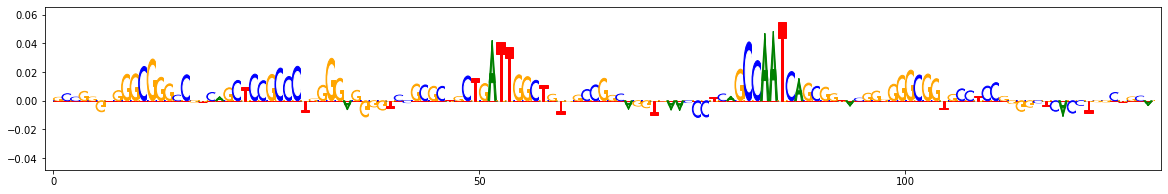

Done 0 examples of 1


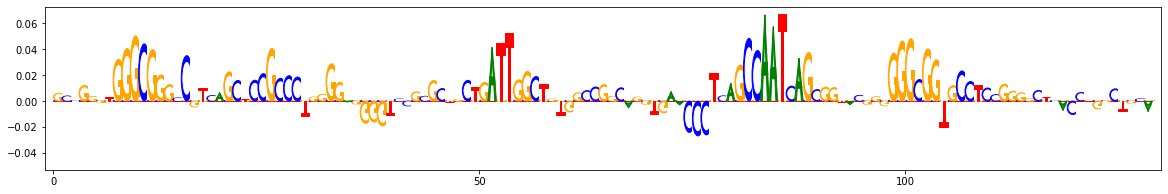

Done 0 examples of 1


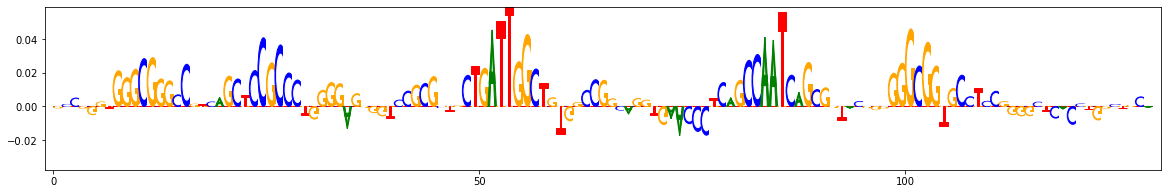

Done 0 examples of 1


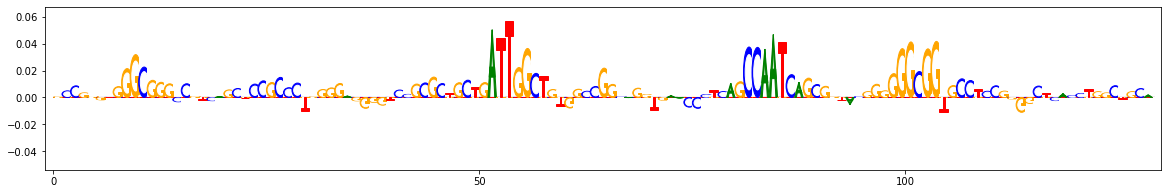

In [183]:
SLICE_START=1041
SLICE_END=1170

for x in CELL_STATES:
    counts_shap_scores = model_count_explainers[x].shap_values(
            [seq, np.zeros((seq.shape[0], 1))], progress_message=100)
    projected_shap_scores = np.multiply(seq, counts_shap_scores[0])
    
    fig, ax = plt.subplots()
    viz_sequence.plot_weights_given_ax(ax, projected_shap_scores[0][SLICE_START:SLICE_END], 
                                       subticks_frequency=50,
                                      figsize=(10,3))
    ax.set_ylim(explain_lower_lims[x], explain_upper_lims[x])
    plt.show()

In [ ]:
projected_shap_scores[projected_shap_scores!=0].shape

In [179]:
f = open("./vignette_intermediate/{}.prom.{}.{}.counts.explain.tsv".format(GENE, LOC_CHR, LOC_CENTER), "w")

f.write("\t".join(["cluster_idx", "lower_lim", "upper_lim"] + [str(x) for x in list(range(1,MODEL_OUT_LEN+1))]) + "\n")

for x in CELL_STATES:
    counts_shap_scores = model_count_explainers[x].shap_values(
            [seq, np.zeros((seq.shape[0], 1))], progress_message=100)
    
    projected_shap_scores = np.multiply(seq, counts_shap_scores[0])
    projected_shap_scores = np.squeeze(projected_shap_scores).sum(-1) # remove last axis
    
    # slice to keep only out-len length
    mid = len(projected_shap_scores)//2
    projected_shap_scores = projected_shap_scores[mid-(MODEL_OUT_LEN//2):mid+(MODEL_OUT_LEN//2)]
    
    f.write('\t'.join([str(x), 
                       str(explain_lower_lims[x]),
                       str(explain_upper_lims[x])] + [str(y) for y in projected_shap_scores]) + '\n')
    
f.close()

Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1


### Perturbations (for CDH1 promoter)

In [218]:
raw_seq_str = str(hg38[LOC_CHR][LOC_CENTER-(MODEL_INP_LEN)//2:LOC_CENTER+(MODEL_INP_LEN)//2])

In [1]:
MOT1_START = 1076
MOT1_END = 1082

MOT2_START = 1107
MOT2_END = 1113

MOT3_START = 1158
MOT3_END = 1164

In [2]:
print(raw_seq_str[MOT1_START:MOT1_END])
print(raw_seq_str[MOT2_START:MOT2_END])
print(raw_seq_str[MOT3_START:MOT3_END])

NameError: name 'raw_seq_str' is not defined

In [242]:
rep_seq = "TTTTTT"

mot1_per_seq = raw_seq_str[:MOT1_START] + rep_seq + raw_seq_str[MOT1_END:]
mot2_per_seq = raw_seq_str[:MOT2_START] + rep_seq + raw_seq_str[MOT2_END:]
mot3_per_seq = raw_seq_str[:MOT3_START] + rep_seq + raw_seq_str[MOT3_END:]
all_mot_per_seq = raw_seq_str[:MOT1_START] + rep_seq + raw_seq_str[MOT1_END:MOT2_START] + \
                  rep_seq + raw_seq_str[MOT2_END:MOT3_START] + \
                  rep_seq + raw_seq_str[MOT3_END:]

In [243]:
all_seqs = one_hot.dna_to_one_hot([raw_seq_str, 
                                   mot1_per_seq,
                                   mot2_per_seq,
                                   mot3_per_seq,
                                   all_mot_per_seq])

all_seqs.shape

(5, 2346, 4)

In [244]:
all_diffs = []

for x in CELL_STATES:
    prof, cts = models[x].predict([all_seqs, 
                      np.zeros((all_seqs.shape[0],1)), 
                      np.zeros((all_seqs.shape[0],MODEL_OUT_LEN,2))])
    
    all_diffs.append(cts[1:,0]-cts[0,0])

In [246]:
import seaborn as sns

<AxesSubplot:>

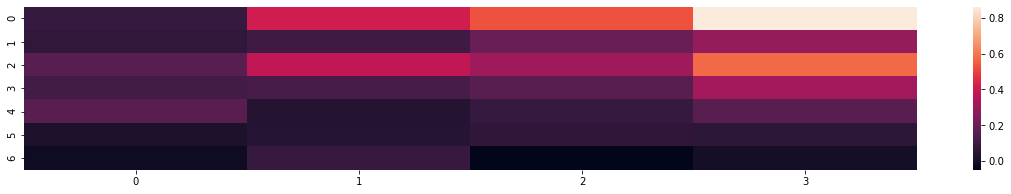

In [247]:
sns.heatmap(np.array(all_diffs))

In [249]:
f = open("./vignette_intermediate/{}.prom.{}.{}.perturb.lfc.tsv".format(GENE, LOC_CHR, LOC_CENTER), "w")

f.write("\t".join(["cluster_idx", "mot1_log2fc", "mot2_log2fc", "mot3_log2fc", "all_log2fc"]) + "\n")

for i,x in enumerate(CELL_STATES):    
    f.write('\t'.join([str(x)] + \
                       [str(y) for y in all_diffs[i]/np.log(2)])+'\n')
    
f.close()